# Permutations

In [4]:
import os, sys
import pandas as pd
import numpy as np
from time import time

from statsmodels.stats.multitest import fdrcorrection
from sklearn.cluster import KMeans

from method2 import read_bic_table, write_bic_table
from method2 import flip_direction, generate_null_dist, calc_e_pv

In [5]:
exprs_file ="/home/olya/SFU/Breast_cancer/Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"
out_dir = os.getcwd()+"/results/"
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

In [7]:
FDR = 0.01
all_bics = {}
all_bic_counts = []

for a in [1.0,0.5,0.25,0.125,2,4,8]:   
    bic_fname = "results/TCGA-micro_13K.1.alpha="+str(a)+",beta_K=1.0,pv=0.05.biclusters.tsv"
    bics = read_bic_table(bic_fname)
    bic_fname = ".".join(bic_fname.split(".")[:-1])
    bics["genes"] = bics["genes"].apply(lambda x:" ".join(sorted(x)))
    bics["samples"] = bics["samples"].apply(lambda x:" ".join(sorted(x)))
    bics = bics.sort_values(by="avgSNR",ascending = False)
    
    # of biclusters of similar genes, keep those with higher SNR 
    print("\tAll biclsuters:",bics.shape[0])
    bics = bics.drop_duplicates(subset = "genes") # duplicates appear when alpha is large
    print("\t\tdeduplicated:",bics.shape[0])
    N = exprs.shape[1]

    # flip too large biclusters with > N/2 samples
    #print("\t\tflip %s biclusters"%bics.loc[bics["n_samples"]>N/2,:].shape[0])
    bics.loc[bics["n_samples"]>N/2,"direction"] = bics.loc[bics["n_samples"]>N/2,"direction"].apply(flip_direction)
    bics.loc[bics["n_samples"]>N/2,"n_samples"] = bics.loc[bics["n_samples"]>N/2,"n_samples"]*-1+N
    
    all_bics[bic_fname] = bics
    bic_counts = bics.loc[:,["n_genes","genes"]].groupby("n_genes").agg("count")
    
    bic_counts = bics.loc[:,["n_genes","genes"]].groupby("n_genes").agg("count")
    bic_counts.columns = [bic_fname]
    all_bic_counts.append(bic_counts)

	All biclsuters: 884
		deduplicated: 876
	All biclsuters: 1034
		deduplicated: 1024
	All biclsuters: 1257
		deduplicated: 1250
	All biclsuters: 975
		deduplicated: 967
	All biclsuters: 652
		deduplicated: 642
	All biclsuters: 406
		deduplicated: 399
	All biclsuters: 227
		deduplicated: 222


In [10]:
# define maximal number of biclusters of given size per run
all_bic_counts= pd.concat(all_bic_counts,axis=1)
all_bic_counts= all_bic_counts.fillna(0)
g_sizes = all_bic_counts.index.values
# number of permutations
n_permutations = all_bic_counts.max(axis=1).apply(lambda x: max(int(x/FDR),100)).to_dict()

# generate null distributions
t0 = time()
SNR_dists = {}
for g_size in g_sizes:
    n_perm = int(n_permutations[g_size])
    print("size: %s - %s permutations"%(g_size,n_perm))
    t1 = time()
    snr_dist = generate_null_dist(exprs,g_size=g_size,n_permutations=n_perm)
    print("\tSNR=",round(np.quantile(snr_dist,0.95),2),round(time()-t1,2),"s")
    SNR_dists[g_size] = snr_dist
print("Time to generate null distributions:",round(time()-t0,2),file =sys.stderr)

size: 2 - 111800 permutations
	SNR= 0.92 564.18 s
size: 3 - 9600 permutations
	SNR= 0.71 57.06 s
size: 4 - 2800 permutations
	SNR= 0.61 16.37 s
size: 5 - 400 permutations
	SNR= 0.54 2.37 s
size: 6 - 200 permutations
	SNR= 0.49 1.21 s
size: 7 - 500 permutations
	SNR= 0.49 3.14 s
size: 8 - 300 permutations
	SNR= 0.44 1.87 s
size: 9 - 200 permutations
	SNR= 0.43 1.24 s
size: 11 - 100 permutations
	SNR= 0.39 0.67 s
size: 12 - 300 permutations
	SNR= 0.4 1.87 s
size: 13 - 100 permutations
	SNR= 0.42 0.64 s
size: 14 - 200 permutations
	SNR= 0.38 1.25 s
size: 16 - 100 permutations
	SNR= 0.38 0.66 s
size: 17 - 100 permutations
	SNR= 0.37 0.66 s
size: 20 - 100 permutations
	SNR= 0.36 3.47 s
size: 21 - 200 permutations
	SNR= 0.36 7.61 s
size: 22 - 100 permutations
	SNR= 0.36 3.79 s
size: 24 - 100 permutations
	SNR= 0.35 3.14 s
size: 25 - 100 permutations
	SNR= 0.34 3.2 s
size: 26 - 200 permutations
	SNR= 0.36 8.19 s
size: 27 - 200 permutations
	SNR= 0.36 8.6 s
size: 30 - 100 permutations
	SNR= 0.

Time to generate null distributions: 925.98


In [20]:
for bic_fname in all_bics.keys():
    bics = all_bics[bic_fname]
    fdr_bics = []
    for g_size in g_sizes:
        df = bics.loc[bics["n_genes"]==g_size,:]
        snr_dist = SNR_dists[g_size]
        # calculate empirical p-val
        df = df.apply(lambda row: calc_e_pv(row,snr_dist),axis=1)
        if df.shape[0]>0:
            # apply BH-correction
            rejected, q_val = fdrcorrection(df["e_pval"], method='indep', is_sorted=False)
            df["q_val"] = q_val
            n_passed = df.loc[df["q_val"]<=FDR,:].shape[0]
            print("\t%s biclusters with %s genes"%(n_passed,g_size),file=sys.stdout)
            fdr_bics.append(df)
    fdr_bics = pd.concat(fdr_bics,axis=0)
    
    print(bic_fname,":\tTotal biclusters passed:",fdr_bics.loc[fdr_bics["q_val"]<=FDR,:].shape[0],file=sys.stdout)
    write_bic_table(fdr_bics, bic_fname+".qval.tsv",to_str=False)
    fdr_bics = fdr_bics.loc[fdr_bics["q_val"]<=FDR,:]
    write_bic_table(fdr_bics,bic_fname+".FDR_"+str(FDR)+".tsv",to_str=False)
    #all_bics[bic_fname] = fdr_bics

	0 biclusters with 2 genes
	17 biclusters with 3 genes
	7 biclusters with 4 genes
	4 biclusters with 5 genes
	3 biclusters with 7 genes
	2 biclusters with 8 genes
	1 biclusters with 9 genes
	1 biclusters with 12 genes
	1 biclusters with 13 genes
	1 biclusters with 16 genes
	1 biclusters with 20 genes
	1 biclusters with 21 genes
	1 biclusters with 25 genes
	1 biclusters with 27 genes
	0 biclusters with 31 genes
	1 biclusters with 61 genes
	0 biclusters with 84 genes
	1 biclusters with 123 genes
	1 biclusters with 154 genes
results/TCGA-micro_13K.1.alpha=1.0,beta_K=1.0,pv=0.05.biclusters :	Total biclusters passed: 44
	0 biclusters with 2 genes
	15 biclusters with 3 genes
	3 biclusters with 4 genes
	0 biclusters with 8 genes
	1 biclusters with 11 genes
	0 biclusters with 12 genes
	1 biclusters with 13 genes
	1 biclusters with 31 genes
	1 biclusters with 35 genes
	0 biclusters with 63 genes
	1 biclusters with 75 genes
	1 biclusters with 129 genes
results/TCGA-micro_13K.1.alpha=0.5,beta_K=1

### ERBB2 bicluster

In [94]:
import seaborn as sns
g1 = ["CASC3","ERBB2","FBXL20","GRB7","MED1","MED24","ORMDL3","PSMD3","STARD3","WIPF2"]
g2 = ["ADRB1","BPTF","CHGA","CNGB3","COX7B2","CSMD1","CST5","GJB7","GUCY1A2","HS3ST5","HTR2C","HUS1B","JPH3"]

In [96]:
s = ["TCGA-A1-A0SM-01","TCGA-A2-A04W-01","TCGA-A2-A04X-01","TCGA-A2-A0CX-01","TCGA-A2-A0D1-01","TCGA-A2-A0EY-01","TCGA-A2-A0SY-01","TCGA-A2-A0T1-01","TCGA-A2-A0YG-01","TCGA-A2-A0YJ-01","TCGA-A8-A076-01","TCGA-A8-A07B-01","TCGA-A8-A07I-01","TCGA-A8-A07P-01","TCGA-A8-A081-01","TCGA-A8-A08B-01","TCGA-A8-A08J-01","TCGA-A8-A08S-01","TCGA-A8-A08X-01","TCGA-A8-A097-01","TCGA-A8-A09A-01","TCGA-A8-A09I-01","TCGA-A8-A0A7-01","TCGA-AN-A041-01","TCGA-AN-A0FT-01","TCGA-AN-A0FV-01","TCGA-AO-A0JL-01","TCGA-AO-A0JM-01","TCGA-AO-A12D-01","TCGA-AQ-A04H-01","TCGA-AR-A0TQ-01","TCGA-AR-A0TX-01","TCGA-AR-A1AT-01","TCGA-AR-A1AX-01","TCGA-B6-A0I9-01","TCGA-B6-A0IG-01","TCGA-B6-A0RH-01","TCGA-BH-A0AW-01","TCGA-BH-A0B7-01","TCGA-BH-A0DD-01","TCGA-BH-A0EE-01","TCGA-BH-A0HY-01","TCGA-BH-A18R-01","TCGA-BH-A18U-01","TCGA-BH-A1EV-01","TCGA-C8-A12M-01","TCGA-C8-A12P-01","TCGA-C8-A12Q-01","TCGA-C8-A12Z-01","TCGA-C8-A132-01","TCGA-C8-A135-01","TCGA-C8-A137-01","TCGA-C8-A138-01","TCGA-C8-A1HF-01","TCGA-C8-A1HL-01","TCGA-E2-A105-01","TCGA-E2-A14P-01","TCGA-E2-A14V-01","TCGA-E2-A14Y-01","TCGA-E2-A152-01","TCGA-E2-A15E-06","TCGA-E2-A15H-01","TCGA-E2-A1B0-01","TCGA-E2-A1B1-01"]

<AxesSubplot:>

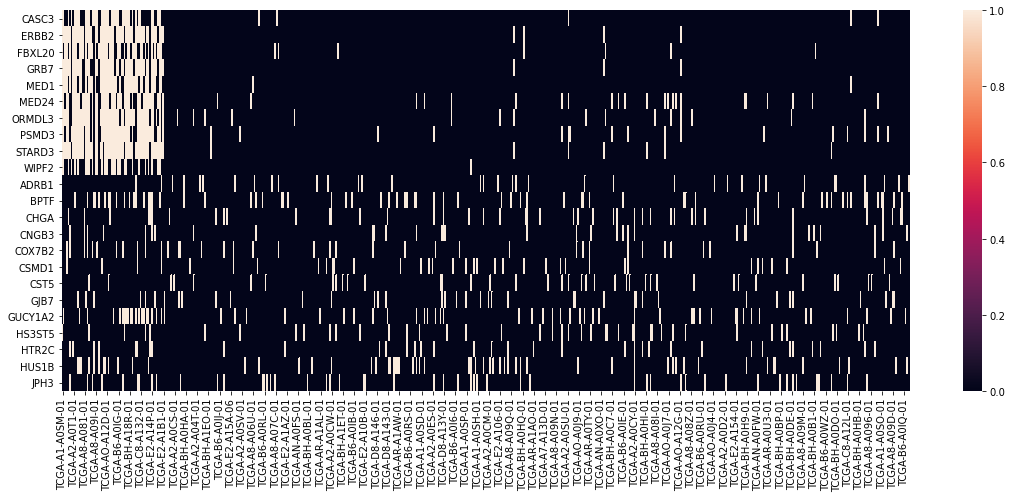

In [107]:
df = pd.read_csv("tmp_results/TCGA-micro_13K.pv=0.05,direction=UP.bin_exprs.tsv",sep="\t",index_col=0).T
fig, ax = plt.subplots(figsize=(19,7))
sns.heatmap(df.loc[g1+g2,s+list(set(exprs.columns).difference(s))],ax=ax)

<AxesSubplot:>

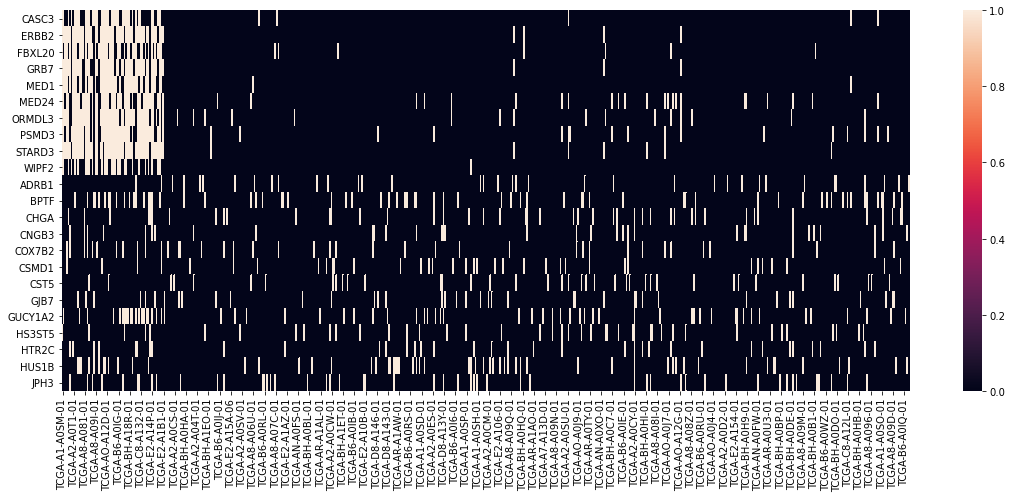

In [108]:
df = pd.read_csv("results/TCGA-micro_13K.1.pv=0.001,direction=UP.bin_exprs.tsv",sep="\t",index_col=0).T
fig, ax = plt.subplots(figsize=(19,7))
sns.heatmap(df.loc[g1+g2,s+list(set(exprs.columns).difference(s))],ax=ax)